# Fast training with MONAI features

[Disclaimer: This tutorial was adapted from the official MONAI ["Fast training tutorial"](https://github.com/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb).]

This tutorial shows a regular PyTorch training program and a MONAI optimized training program, and compares the performance.  
The steps for acceleration include:
1. Automatic mixed precision ([AMP](https://developer.nvidia.com/automatic-mixed-precision)).
2. CacheDataset to pre-computing all deterministic transforms in the pre-processing pipeline.
3. Moving data to GPU and caching, then execute random augmentation transforms on GPU.
4. Multi-threads `ThreadDataLoader` is faster than PyTorch DataLoader in light-weight tasks.
5. Use MONAI `DiceCE` loss instead of regular `Dice` loss.
6. Use MONAI `Novograd` optimizer instead of regular `Adam` optimizer.

It's modified from the Spleen 3D segmentation tutorial notebook, the Spleen dataset can be downloaded from http://medicaldecathlon.com/.


## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import math
import os
import shutil
import tempfile
import time
from pprint import pprint

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.optimizers import Novograd
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToDeviced,
    EnsureTyped,
    EnsureType,
)
from monai.utils import get_torch_version_tuple, set_determinism

print_config()

if get_torch_version_tuple() < (1, 6):
    raise RuntimeError(
        "AMP feature only exists in PyTorch version greater than v1.6."
    )

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.8.1+209.gcc9c0664
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+2c916ef
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: cc9c06649bbc94e3dda9bda36a99d369934bb7b0
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.0
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.63.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.25.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
#directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = os.path.join(os.getcwd(),'..','data')
print(f"root dir is: {root_dir}")

root dir is: /data/Projects/Essen_Workshop/sources/exercise2_radiology/../data


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [4]:
print(os.getenv("SPLEEN_TAR_URL"))

file:////data/Projects/Essen_Workshop/sources/data/Task09_Spleen.tar


In [5]:
resource = os.getenv("SPLEEN_TAR_URL")#"https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)
    print("Data downloaded and extracted to 'Task09_Spleen' directory.")
else:
    print("'Task09_Spleen' directory exists. Data download skipped.")

'Task09_Spleen' directory exists. Data download skipped.


## Set MSD Spleen dataset path

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz"))
)
train_labels = sorted(
    glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz"))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

print('\nExample dicts in training dataset (N=3):\n')
pprint(train_files[:3])


Example dicts in training dataset (N=3):

[{'image': '/data/Projects/Essen_Workshop/sources/exercise2_radiology/../data/Task09_Spleen/imagesTr/spleen_10.nii.gz',
  'label': '/data/Projects/Essen_Workshop/sources/exercise2_radiology/../data/Task09_Spleen/labelsTr/spleen_10.nii.gz'},
 {'image': '/data/Projects/Essen_Workshop/sources/exercise2_radiology/../data/Task09_Spleen/imagesTr/spleen_12.nii.gz',
  'label': '/data/Projects/Essen_Workshop/sources/exercise2_radiology/../data/Task09_Spleen/labelsTr/spleen_12.nii.gz'},
 {'image': '/data/Projects/Essen_Workshop/sources/exercise2_radiology/../data/Task09_Spleen/imagesTr/spleen_13.nii.gz',
  'label': '/data/Projects/Essen_Workshop/sources/exercise2_radiology/../data/Task09_Spleen/labelsTr/spleen_13.nii.gz'}]


## Setup transforms for training and validation

In [7]:
def transformations(fast=False):
    train_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # pre-compute foreground and background indexes
        # and cache them to accelerate training
        FgBgToIndicesd(
            keys="label",
            fg_postfix="_fg",
            bg_postfix="_bg",
            image_key="image",
        ),
        # change to execute transforms with Tensor data
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )
    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            fg_indices_key="label_fg",
            bg_indices_key="label_bg",
        ),
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )

    return Compose(train_transforms), Compose(val_transforms)

## Define the training progress
The cell below implements a typical PyTorch training loop, with regular classes like `Dataset`, `DataLoader`, `Adam` optimizer and `Dice` loss to train the model.

There are several locations where your job will be to implement various forms of acceleration (see cells below).

In [16]:
def train_process(fast=False, max_epochs=100):
    learning_rate = 2e-4
    val_interval = 1  # do validation for every epoch

    train_trans, val_trans = transformations(fast=fast)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        # as `RandCropByPosNegLabeld` crops from the cached content and `deepcopy`
        # the crop area instead of modifying the cached value, we can set `copy_cache=False`
        # to avoid unnecessary deepcopy of cached content in `CacheDataset`
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
            copy_cache=False,
        )
        val_ds = CacheDataset(
            data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5, copy_cache=False
        )
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)
        loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        # num_worker=4 is the best parameter according to the test
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)

    device = torch.device("cuda:0")
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

    # set Novograd optimizer for MONAI training
    if fast:
        # Novograd paper suggests to use a bigger LR than Adam,
        # because Adam does normalization by element-wise second moments
        optimizer = Novograd(model.parameters(), learning_rate * 10)
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()
    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            # set AMP for MONAI training
            if fast:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
            print(
                f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                f" step time: {(time.time() - step_start):.4f}"
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    # set AMP for MONAI validation
                    if fast:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(
                                val_inputs, roi_size, sw_batch_size, model
                            )
                    else:
                        val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model
                        )
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(
                        time.time() - total_start
                    )
                    torch.save(model.state_dict(), "best_metric_model.pth")
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(
            f"time consuming of epoch {epoch + 1} is:"
            f" {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

## Enable determinism and execute regular PyTorch training

Run the cell below for a few epochs of training (e.g. `max_epochs = 5`). Observe and note down the training times per epoch.

Once there is time (i.e. after the workshop), feel free to run a full convergence (i.e. max_epochs = 300) to lay a baseline for full training duration and epoch durations.

In [17]:
max_epochs = 300
set_determinism(seed=0)
regular_start = time.time()
(
    epoch_num,
    epoch_loss_values,
    metric_values,
    epoch_times,
    best,
    train_time,
) = train_process(fast=False, max_epochs=max_epochs)
total_time = time.time() - regular_start
print(
    f"total time of {epoch_num} epochs with regular PyTorch training: {total_time:.4f}"
)

----------
epoch 1/300
1/8, train_loss: 0.6697 step time: 0.7705
2/8, train_loss: 0.6850 step time: 0.5486
3/8, train_loss: 0.6906 step time: 0.5111
4/8, train_loss: 0.6771 step time: 0.4964
5/8, train_loss: 0.6635 step time: 0.6932
6/8, train_loss: 0.6723 step time: 0.4844
7/8, train_loss: 0.6560 step time: 0.4746
8/8, train_loss: 0.6647 step time: 0.4747
epoch 1 average loss: 0.6724
saved new best metric model
current epoch: 1 current mean dice: 0.0395 best mean dice: 0.0395 at epoch: 1
time consuming of epoch 1 is: 43.7449
----------
epoch 2/300
1/8, train_loss: 0.6385 step time: 0.6710
2/8, train_loss: 0.6475 step time: 0.4921
3/8, train_loss: 0.6486 step time: 0.4885
4/8, train_loss: 0.6520 step time: 0.4914
5/8, train_loss: 0.6362 step time: 0.6999
6/8, train_loss: 0.6251 step time: 0.4800
7/8, train_loss: 0.6447 step time: 0.4768
8/8, train_loss: 0.6402 step time: 0.4768
epoch 2 average loss: 0.6416
saved new best metric model
current epoch: 2 current mean dice: 0.2740 best mean

## Enable determinism and execute MONAI optimized training

For MONAI fast training, your task is to introduce the following 6 acceleration features into the `train_process()` function:
1. `AMP` (auto mixed precision): AMP is an important feature in PyTorch since v1.6, and NVIDIA CUDA 11 added strong support for AMP and significantly improved training speed. Check the [AMP website](https://developer.nvidia.com/automatic-mixed-precision) (section "PyTorch") for the 7 lines of code that are required to use AMP and gradient scaling in your optimization loop (note: the mentioned `autocast()` function is part of the torch module `torch.cuda.amp.autocast()`).
2. `CacheDataset`: The [CacheDataset](https://docs.monai.io/en/stable/data.html#cachedataset) class provides a cache mechanism that can load and cache all or parts of the training data, including the results from all deterministic transforms.
3. `ToDeviced`: The [ToDeviced](https://docs.monai.io/en/stable/transforms.html#todeviced) class moves batch data to GPU. Combined with `CacheDataset`, all following random transforms are executed on GPU directly. This avoids CPU -> GPU syncs in every epoch. Please note that not all the MONAI transforms support GPU operation so far, this is a continuous work-in-progress.
4. `ThreadDataLoader`: The [ThreadDataLoader](https://docs.monai.io/en/stable/data.html#threaddataloader) class uses multi-threads instead of multi-processing, which yields faster results than `DataLoader` in light-weight task. We can use it here as we already cached the results of most computation, and remaining transforms are executed on the GPU.
5. `Novograd` optimizer: The [Novograd](https://docs.monai.io/en/stable/optimizers.html#monai.optimizers.Novograd) optimizer is based on the paper "Stochastic Gradient Methods with Layer-wise Adaptive Moments for Training of Deep Networks" ([arXiv](https://arxiv.org/pdf/1905.11286.pdf)). It can simply replace Adam, with an increased learning rate (e.g. 10x). 
6. `DiceCE` loss function: The [DiceCE](https://docs.monai.io/en/stable/losses.html#diceceloss) class computes both Dice loss and Cross Entropy Loss, and returns a weighted sum of these two losses.

Implement these steps one by one, and feel free to run max 5 epochs of training in the cell below after each acceleration, to get a sense for the acceleration contributions. 

Once there is time (i.e. after the workshop), feel free to run as many epochs as without acceleration (e.g. `max_epochs = 300`) to be able to compare the final outcomes.  

In [18]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True, max_epochs=max_epochs)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

Loading dataset: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


----------
epoch 1/300
1/8, train_loss: 1.5943 step time: 0.6677
2/8, train_loss: 1.5951 step time: 0.3309
3/8, train_loss: 1.5595 step time: 0.3312
4/8, train_loss: 1.5465 step time: 0.3450
5/8, train_loss: 1.4930 step time: 0.3312
6/8, train_loss: 1.4713 step time: 0.3269
7/8, train_loss: 1.4302 step time: 0.3256
8/8, train_loss: 1.3683 step time: 0.3124
epoch 1 average loss: 1.5073
saved new best metric model
current epoch: 1 current mean dice: 0.4049 best mean dice: 0.4049 at epoch: 1
time consuming of epoch 1 is: 5.0374
----------
epoch 2/300
1/8, train_loss: 1.3381 step time: 0.3354
2/8, train_loss: 1.2778 step time: 0.3288
3/8, train_loss: 1.2426 step time: 0.3240
4/8, train_loss: 1.2046 step time: 0.3341
5/8, train_loss: 1.1296 step time: 0.3356
6/8, train_loss: 1.0936 step time: 0.3223
7/8, train_loss: 1.0546 step time: 0.3104
8/8, train_loss: 0.9960 step time: 0.3280
epoch 2 average loss: 1.1671
saved new best metric model
current epoch: 2 current mean dice: 0.5111 best mean 

## Plot training loss and validation metrics

This cell plots the training metrics and ideally should be executed after a full training run (with e.g. `max_epochs = 300`).

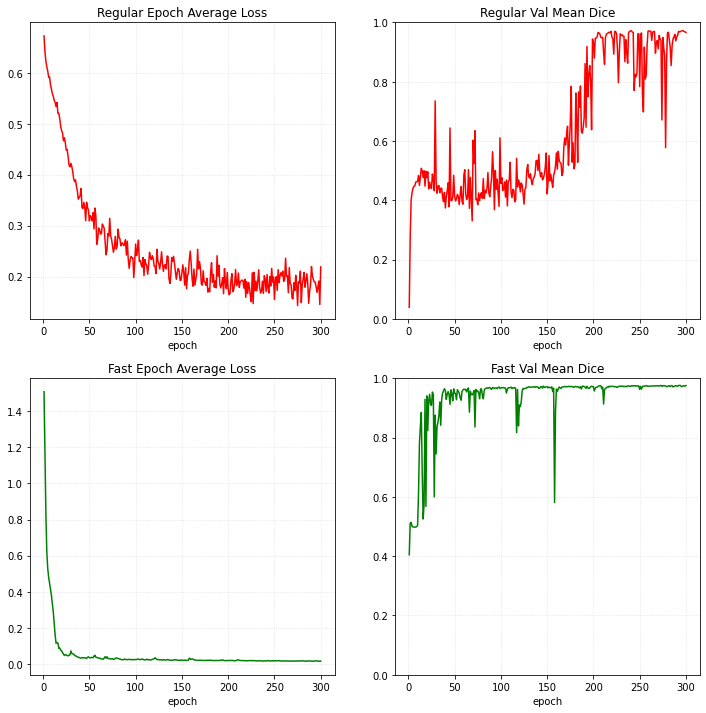

In [19]:
plt.figure("train", (12, 12))
plt.subplot(2, 2, 1)
plt.title("Regular Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 2)
plt.title("Regular Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 3)
plt.title("Fast Epoch Average Loss")
x = [i + 1 for i in range(len(m_epoch_loss_values))]
y = m_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")

plt.subplot(2, 2, 4)
plt.title("Fast Val Mean Dice")
x = [i + 1 for i in range(len(m_metric_values))]
y = m_metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")
plt.show()

## Plot total time and every epoch time

This cell plots the training times and, as above, ideally should be executed after a full training run (with e.g. `max_epochs = 300`).

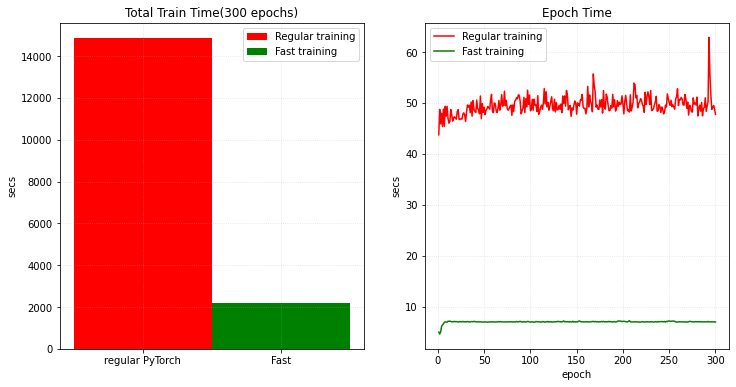

-------------------------------
Total speed-up: 6.852 x
-------------------------------


In [20]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Total Train Time(300 epochs)")
plt.bar(
    "regular PyTorch", total_time, 1, label="Regular training", color="red"
)
plt.bar("Fast", m_total_time, 1, label="Fast training", color="green")
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(max_epochs)]
plt.xlabel("epoch")
plt.ylabel("secs")
plt.plot(x, epoch_times, label="Regular training", color="red")
plt.plot(x, m_epoch_times, label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

print('-------------------------------')
print(f'Total speed-up: {total_time/m_total_time:.3f} x')
print('-------------------------------')

## Plot total time to achieve metrics

This cell plots the times and speed-ups until reaching target Dice values (i.e. 0.9/0.93/0.95/0.97). As above, this should be ideally executed after a full training run (with e.g. `max_epochs = 300`).

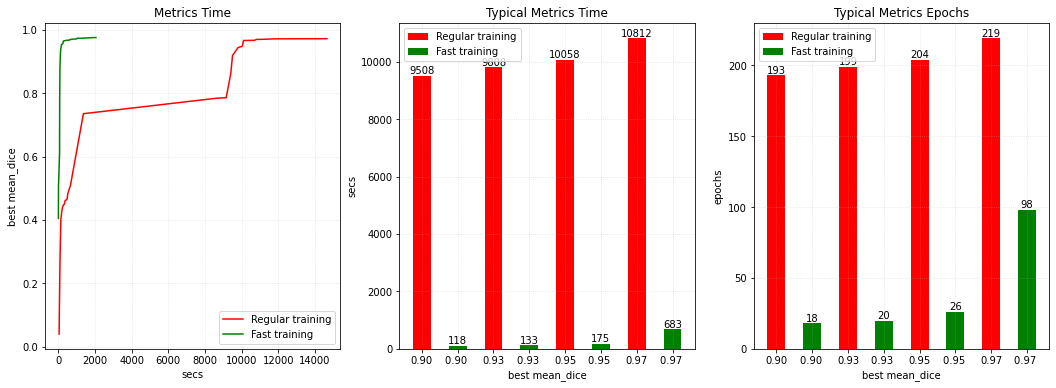

In [22]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[2][i]
    return -1


def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[1][i]
    return -1


def get_label(index):
    if index == 0:
        return "Regular training"
    elif index == 1:
        return "Fast training"
    else:
        return None


plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Metrics Time")
plt.xlabel("secs")
plt.ylabel("best mean_dice")
plt.plot(best[2], best[0], label="Regular training", color="red")
plt.plot(m_best[2], m_best[0], label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 2)
plt.title("Typical Metrics Time")
plt.xlabel("best mean_dice")
plt.ylabel("secs")
labels = ["0.90", "0.90 ", "0.93", "0.93 ", "0.95", "0.95 ", "0.97", "0.97 "]
x_values = [0.9, 0.9, 0.93, 0.93, 0.95, 0.95, 0.97, 0.97]
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_time(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 3)
plt.title("Typical Metrics Epochs")
plt.xlabel("best mean_dice")
plt.ylabel("epochs")
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_epochs(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [15]:
# Uncomment if you want to delete data.
#if directory is None:
#    shutil.rmtree(root_dir)

## Summary

In the above tutorial, you went through several steps of accelerating your segmentation model training. Running a full training until convergence (e.g. `max_epochs = 300`) probably takes too long for the scope of this workshop. 

In the official MONAI ["Fast training tutorial"](https://github.com/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb), it is stated that with a V100 GPU, the developers are able to achieve training convergence at a validation mean dice of `0.95` within `1 minute`. This corresponds to an approximately `200x` speedup compared with the Pytorch regular implementation when achieving same metric. And every epoch is `20x` faster than regular training.

There are more tips and tricks for accelerated training with MONAI. For more details, please visit the official ["Fast Model Training Guide"](https://github.com/Project-MONAI/tutorials/blob/master/acceleration/fast_model_training_guide.md) in the [MONAI tutorials](https://github.com/Project-MONAI/tutorials) GitHub repository. 

